# PROJET NLP IMDB

## imports

In [1]:
import nltk
nltk.download('stopwords') 
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/baguidou/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/baguidou/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
#!pip install wordcloud
#!pip install pyLDAvis

In [3]:
#scrap
import requests
from bs4 import BeautifulSoup

# Data manipulation
import numpy as np
import pandas as pd
pd.options.display.max_colwidth = 100

# Text preprocessing and modelling
from nltk.tokenize import RegexpTokenizer
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.pipeline import Pipeline

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', context='talk')

from wordcloud import WordCloud

# Warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

# Stopwords
stop_words = set(ENGLISH_STOP_WORDS).union(stopwords.words('english'))
stop_words = stop_words.union(['let', 'mayn', 'ought', 'oughtn', 
                               'shall'])
print(f"Number of stop words: {len(stop_words)}")

Number of stop words: 383


## SCRAP IMDB

In [4]:
def scraping():   
    
    #------------------------------------------------------------------------------------------------------
    #scrap data on url imdb
    #return dataframe
    #------------------------------------------------------------------------------------------------------
    
    liste_synopsis = []
    titres = []
    summary = []

    for i in range(1, 1001, 50):

        #avancement
        print(f"Scrap de la partie {i} sur {i+49}")

        # connect db
        url = f"https://www.imdb.com/search/title/?title_type=feature&num_votes=5000,&sort=user_rating,desc&start={i}&ref_=adv_nxt"
        response = requests.get(url)
        soup = BeautifulSoup(response.text, 'html.parser')
        soup = soup.find_all(class_='lister-item-content')

        # scrap summary
        summary += [element.find_all("p", class_='text-muted')[-1].text.replace(
            "\n", "").replace("See full summary\xa0»\n')", "") for element in soup]

        # scrap movies href
        liens = [element.find("a")['href'] for element in soup]

        for lien in liens:

            # connect href
            url_2 = f'https://www.imdb.com{lien}?ref_=adv_li_tt'
            response_2 = requests.get(url_2)
            soup_2 = BeautifulSoup(response_2.content, 'html.parser')

            # scrap synopsis
            liste_synopsis.append(soup_2.find(
                class_='inline canwrap').text.replace("\n", "").strip())

            # scrap titles
            titres.append(soup_2.find('h1').text.replace('\xa0', '').split('(')[0])
            
    return pd.DataFrame({'titres': titres, 'synopsis': liste_synopsis, 'resume': summary})


In [5]:
#df = scraping()

In [6]:
#save in csv
#df.to_csv("imdb_1000.csv", index = False)

In [7]:
df = pd.read_csv('imdb_1000.csv')
df

,titres,synopsis,resume
0,Methagu,"Srilankan Government made Sinhala as the only official language in Srilanka, discriminating Tami...",The Movie shows the true events that happened in Tamileelam to suppress Tamil ethnicity and it i...
1,Hababam Sinifi,"Lazy, uneducated students share a very close bond. They live together in the dormitory, where th...","Lazy, uneducated students share a very close bond. They live together in the dormitory, where th..."
2,Les Évadés,Chronicles the experiences of a formerly successful banker as a prisoner in the gloomy jailhouse...,"Two imprisoned men bond over a number of years, finding solace and eventual redemption through a..."
3,Aynabaji,Ayna is an actor and the prison is his stage. He slips into the characters of the powerful convi...,Ayna is an actor and the prison is his stage. He slips into the characters of the powerful convi...
4,Le Parrain,"The Godfather ""Don"" Vito Corleone is the head of the Corleone mafia family in New York. He is at...",An organized crime dynasty's aging patriarch transfers control of his clandestine empire to his ...
...,...,...,...
995,La Horde sauvage,"It's 1913, and the ""traditional"" American West is dying. Amongst the inhabitants of this dying e...","An aging group of outlaws look for one last big score as the ""traditional"" American West is disa..."
996,On achève bien les chevaux,Gloria is a young woman of the Depression. She has aged beyond her years and feels her life is h...,The lives of a disparate group of contestants intertwine in an inhumanely grueling dance marathon.
997,Ma nuit chez Maud,Thirty-four year old engineer Jean-Louis has just started a new job in Clermont. He leads a rela...,"The rigid principles of a devout Catholic man are challenged during a one-night stay with Maud, ..."
998,Kes,"Bullied at school and ignored and abused at home by his indifferent mother and older brother, Bi...",A working-class English boy spends his free time caring for and training his pet kestrel.


## Delete some keywords

In [8]:
#delete written
df['synopsis'] = df['synopsis'].apply(lambda x: x.replace('Written',''))

#delete family
df['synopsis'] = df['synopsis'].apply(lambda x: x.replace('family',''))

#delete life
df['synopsis'] = df['synopsis'].apply(lambda x: x.replace('life',''))

#delete year
df['synopsis'] = df['synopsis'].apply(lambda x: x.replace('year',''))

## Preprocessing

In [9]:
def preprocess_text(document):
    #------------------------------------------------------------------------------------------------------
    #keep only alpha character group by 3, select somes tag word, remove stop-words, lemmatize words
    #return array of final words 
    #------------------------------------------------------------------------------------------------------
    
    """Preprocess document into normalised tokens."""
    # Tokenise words into alphabetic tokens with minimum length of 3
    tokeniser = RegexpTokenizer(r'[A-Za-z]{3,}')
    tokens = tokeniser.tokenize(document)
    
    # Tag words with POS tag
    pos_map = {'J': 'a', 'N': 'n', 'R': 'r', 'V': 'v'}
    pos_tags = pos_tag(tokens)
    
    # Lowercase and lemmatise 
    lemmatiser = WordNetLemmatizer()
    lemmas = [lemmatiser.lemmatize(t.lower(), pos=pos_map.get(p[0], 'v')) for t, p in pos_tags]
    
    # Remove stopwords
    keywords= [lemma for lemma in lemmas if lemma not in stop_words]
    return keywords

In [10]:
#split Dataset
X_train, X_test = train_test_split(df, test_size=0.2, 
                                   random_state=1)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)

Train size: (800, 3)
Test size: (200, 3)


In [11]:
# Preprocess text
vectoriser = CountVectorizer(analyzer=preprocess_text)
document_term_matrix = vectoriser.fit_transform(X_train['synopsis'])

# Run grid search across parameters of choice
lda = LatentDirichletAllocation(learning_method='online', random_state=0)
param_grid = {'n_components': [2,4,6]}
lda_search = GridSearchCV(lda, param_grid=param_grid, cv=2)
lda_search.fit(document_term_matrix)

# Inspect grid search output
results = pd.DataFrame(lda_search.cv_results_)\
            .sort_values("rank_test_score")
results[['param_n_components', "rank_test_score", 'mean_test_score', 
         'std_test_score']]

,param_n_components,rank_test_score,mean_test_score,std_test_score
0,2,1,-183936.338478,1123.971751
1,4,2,-196289.427430,98.966654
2,6,3,-206782.336607,222.657113


## Model creation

In [12]:
def describe_topics(lda, feature_names, top_n_words=5, show_weight=False):
    #------------------------------------------------------------------------------------------------------
    #show main words of each topics
    #return none
    #------------------------------------------------------------------------------------------------------
    
    """Print top n words for each topic from lda model."""
    normalised_weights = lda.components_ / lda.components_.sum(axis=1)[:, np.newaxis]
    
    for i, weights in enumerate(normalised_weights):  
        print(f"********** Topic {i+1} **********")
        
        if show_weight:
            feature_weights = [*zip(np.round(weights, 4), feature_names)]
            feature_weights.sort(reverse=True)
            print(feature_weights[:top_n_words], '\n')
        
        else:
            top_words = [feature_names[i] for i in weights.argsort()[:-top_n_words-1:-1]]
            print(top_words, '\n')

### Define number of Contents

In [13]:
#Topics creation fon n_components = n

#**************************************
n_components = 2
#**************************************

pipe = Pipeline([('vectoriser', CountVectorizer(analyzer=preprocess_text, min_df=5)),
                 ('lda', LatentDirichletAllocation(n_components=n_components, learning_method='batch', random_state=0))])
pipe.fit(X_train['synopsis'])
# Inspect topics
feature_names = pipe['vectoriser'].get_feature_names()
describe_topics(pipe['lda'], feature_names, top_n_words=20)

********** Topic 1 **********
['war', 'man', 'story', 'love', 'come', 'world', 'make', 'time', 'wife', 'young', 'work', 'great', 'kill', 'day', 'meet', 'film', 'friend', 'new', 'death', 'soon'] 

********** Topic 2 **********
['father', 'young', 'old', 'love', 'man', 'try', 'make', 'time', 'live', 'want', 'son', 'meet', 'film', 'woman', 'friend', 'story', 'know', 'girl', 'com', 'boy'] 



## Transform Train & Viz

In [14]:
pd.options.display.max_colwidth = 50
train = pd.DataFrame(X_train)
columns = ['topic'+str(i+1) for i in range(n_components)]
train[columns] = pipe.transform(X_train['synopsis'])
train.head()

,titres,synopsis,resume,topic1,topic2
382,Le crime était presque parfait,"In London, wealthy Margot Mary Wendice had a b...",A former tennis player tries to arrange his wi...,0.977491,0.022509
994,Patton,"""Patton"" tells the tale of General George S. P...",The World War II phase of the career of contro...,0.798321,0.201679
982,L'arbre aux sabots,The inside a farm in Italy at the end of the ...,Peasant life in a feudal farm in rural Italy a...,0.585057,0.414943
47,Kibar Feyzo,A feudal village in Southeastern Turkey in 197...,A feudal village in Southeastern Turkey in 197...,0.977202,0.022798
521,"Paris, Texas",A man wanders out of the desert after a four ...,"Travis Henderson, an aimless drifter who has b...",0.391284,0.608716


In [15]:
#Create df with Top 1 to 3
train = train.assign(top1=np.nan, prob1=np.nan, top2=np.nan, 
                     prob2=np.nan, top3=np.nan, prob3=np.nan)

top_liste = [f'top{i}' for i in range(1,n_components+1)]
top_prob = [f'prob{i}' for i in range(1,n_components+1)]
last_topic = f'topic{n_components}'

for record in train.index:
    top = train.loc[record, 'topic1':last_topic].astype(float).nlargest(5)
    train.loc[record, top_liste] = top.index
    train.loc[record, top_prob] = top.values
train.drop(['synopsis'], axis=1).head()

,titres,resume,topic1,topic2,top1,prob1,top2,prob2,top3,prob3
382,Le crime était presque parfait,A former tennis player tries to arrange his wi...,0.977491,0.022509,topic1,0.977491,topic2,0.022509,NaN,NaN
994,Patton,The World War II phase of the career of contro...,0.798321,0.201679,topic1,0.798321,topic2,0.201679,NaN,NaN
982,L'arbre aux sabots,Peasant life in a feudal farm in rural Italy a...,0.585057,0.414943,topic1,0.585057,topic2,0.414943,NaN,NaN
47,Kibar Feyzo,A feudal village in Southeastern Turkey in 197...,0.977202,0.022798,topic1,0.977202,topic2,0.022798,NaN,NaN
521,"Paris, Texas","Travis Henderson, an aimless drifter who has b...",0.391284,0.608716,topic2,0.608716,topic1,0.391284,NaN,NaN


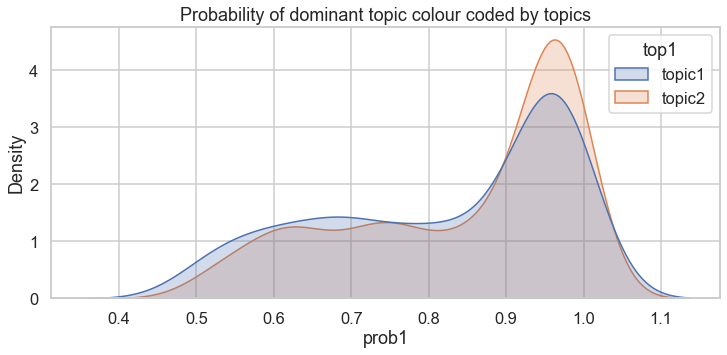

In [16]:
#plot schema
plt.figure(figsize=(12,5))
sns.kdeplot(data=train, x='prob1', hue='top1', shade=True, 
            common_norm=False)
plt.title("Probability of dominant topic colour coded by topics");

In [17]:
df2 = train[['titres','top1']]
df_compare=pd.DataFrame()
df3 = df2.sample(len(df2))

for i in range(1,n_components+1):
    df_compare[f'topic{i}'] = list(df3['titres'][df3['top1'] == f'topic{i}'].head(10))

df_compare

,topic1,topic2
0,La soif du mal,Rane
1,"Le Parrain, 2ᵉ partie",Umberto D.
2,Mandarines,Le bourreau
3,Épouses et concubines,Davaro: Son Eskiya
4,Voyage au bout de l'enfer,Le Grand Chantage
5,Les Émigrants,Divorce à l'italienne
6,La Honte,Drishyam
7,Z,Hera Pheri
8,L'enfer est à lui,Mrtav 'ladan
9,Un homme d'exception,L'âme des guerriers


In [18]:
def inspect_term_frequency(df, vectoriser, n=30):
    #------------------------------------------------------------------------------------------------------
    #show main words sorted for each topics
    #return none
    #------------------------------------------------------------------------------------------------------
    
    """Show top n frequent terms in corpus."""
    document_term_matrix = vectoriser.transform(df)
    document_term_matrix_df = pd.DataFrame(document_term_matrix.toarray(), 
                                           columns=feature_names)
    term_frequency = pd.DataFrame(document_term_matrix_df.sum(axis=0), 
                                  columns=['frequency'])
    return term_frequency.nlargest(n, 'frequency')

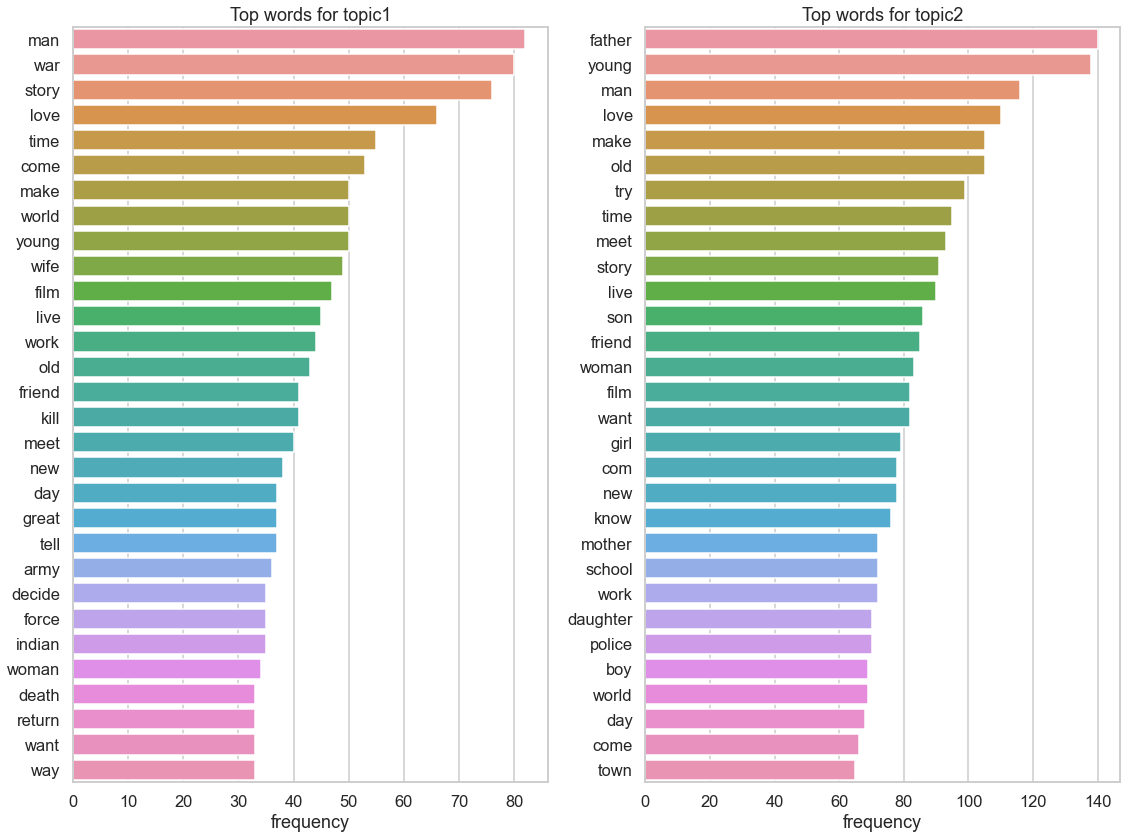

In [19]:
#plot List of Main Words sorted
fig, ax = plt.subplots(1, n_components, figsize=(16,12))
for i in range(n_components):
    topic = 'topic' + str(i+1)
    topic_df = train.loc[train['top1']==topic, 'synopsis']
    freqs = inspect_term_frequency(topic_df, pipe['vectoriser'])
    sns.barplot(data=freqs, x='frequency', y=freqs.index, ax=ax[i])
    ax[i].set_title(f"Top words for {topic}")
plt.tight_layout()

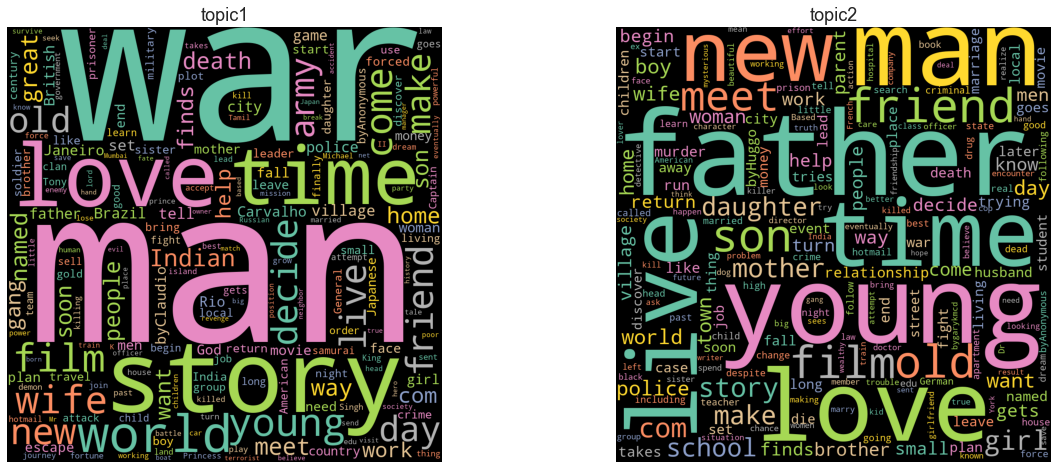

In [20]:
#plot with words
fig, ax = plt.subplots(1, n_components, figsize=(20, 8))
for i in range(n_components):
    topic = 'topic' + str(i+1)
    text = ' '.join(train.loc[train['top1']==topic, 'synopsis'].values)    
    wordcloud = WordCloud(width=1000, height=1000, random_state=1, background_color='Black', 
                          colormap='Set2', collocations=False, stopwords=stop_words).generate(text)
    ax[i].imshow(wordcloud) 
    ax[i].set_title(topic)
    ax[i].axis("off");

## Create name for Topics

In [21]:
topic_mapping = {'topic1': 'bagarre', 
                 'topic2': 'famille'}
train['topic'] = train['top1'].map(topic_mapping)
train[['synopsis', 'topic']].head()

,synopsis,topic
382,"In London, wealthy Margot Mary Wendice had a b...",bagarre
994,"""Patton"" tells the tale of General George S. P...",bagarre
982,The inside a farm in Italy at the end of the ...,bagarre
47,A feudal village in Southeastern Turkey in 197...,bagarre
521,A man wanders out of the desert after a four ...,famille


In [22]:
def assign_topic(document):
    #------------------------------------------------------------------------------------------------------
    #assign a topic from data send
    #return string with topic name
    #------------------------------------------------------------------------------------------------------
    
    """Assign topic to a document using lda model prediction."""
    probabilities = pipe.transform(document)
    topic = probabilities.argmax()
    topic_name = topic_mapping['topic'+str(topic+1)]
    return topic_name

In [23]:
#Test 3 random training values
for i, document in enumerate(X_train.sample(3).values):
    print(f"********** Test example {i+1} **********", '\n')
    print(f"************************************")
    print(f'titre : {document[0]}')
    print(f"************************************")
    print(document[1], '\n')
    print(f"Assigned topic: {assign_topic(np.atleast_1d(document[1]))}", '\n')

********** Test example 1 ********** 

************************************
titre : Kaakkaa Muttai
************************************
It is all about the  and times of two kids Periya Kakka Muttai (Vignesh) and his younger brother Chinna Kaaka Muttai (Ramesh) growing up in a slum, who make their living stealing coal from the railway yard. Their father is in the jail while mother (Ishwarya Rajesh) brings them up. The urchins have their own dreams like any other kids and here, they want to try out a Pizza from the newly opened Pizza shop. Their curiosity about pizza is because, the new shop is opened by Tamil star Silambarasan. They decide that by hook or crook, they will gain entry into the upmarket Pizza shop and have a slice of it with their own money. Will they succeed in their attempt ? byRahul 

Assigned topic: famille 

********** Test example 2 ********** 

************************************
titre : Kôkaku kidôtai 2.0
************************************
A hacker known as the

## Predict Test

In [24]:
#Predict Test values
for i, document in enumerate(X_test.values):
    print(f"********** Test example {i+1} **********", '\n')
    print(f"************************************")
    print(f'titre : {document[0]}')
    print(f"************************************")
    print(document[1], '\n')
    print(f"Assigned topic: {assign_topic(np.atleast_1d(document[1]))}", '\n')

********** Test example 1 ********** 

************************************
titre : Andaz Apna Apna
************************************
Amar and Prem are two rivals who belonging to middle-class families with no scope of future advancement. Both individually, without the knowledge of the other decide to take matters into their hands and find ways to get rich quickly. Chaos and acrimony result when both find each other at loggerheads when both arrive to win the hand of the daughter of multi-millionaire Ram Gopal Bajaj amidst considerable upheavals when Shyam, the twin brother of Ram, decides to do away with Ram and assume his identity and thus take over the estate of the Bajaj . bySonia 

Assigned topic: famille 

********** Test example 2 ********** 

************************************
titre : Tourments
************************************
Francisco is rich, rather strict on principles, and still a bachelor. After meeting Gloria by accident, he is suddenly intent on her becoming his

************************************
titre : Innocence
************************************
Yusuf is released from prison after serving a ten- sentence. He is scared of  outside as he goes to an address given to him by another prisoner. 

Assigned topic: famille 

********** Test example 15 ********** 

************************************
titre : Hannah et ses soeurs
************************************
Hannah, Holly, and Lee are adult sisters from a show business , their boozy actress mother who still believes she's an ingénue that can attract any man she wants, despite still being married to the girls' father, Evan. Hannah, on her second marriage to a man named Elliot, a financial advisor, is the success of the , taking a break from her acting career to raise her children. Everyone turns to her for advice, while she never talks to others about what she needs or feels. Her first husband, Mickey, is a comedy show writer and hypochondriac, who is going through a crisis as he mistakenly

Assigned topic: famille 

********** Test example 29 ********** 

************************************
titre : Rebecca
************************************
A shy lady's companion, staying in Monte Carlo with her stuffy employer, meets the wealthy Maxim de Winter (Sir Laurence Olivier). She and Max fall in love, marry, and return to Manderley, his large country estate in Cornwall. Max is still troubled by the death of his first wife, Rebecca, in a boating accident the  before. The second Mrs. de Winter (Joan Fontaine) clashes with the housekeeper, Mrs. Danvers (Dame Judith Anderson), and discovers that Rebecca still has a strange hold on everyone at Manderley. byCol Needham <col@imdb.com> 

Assigned topic: famille 

********** Test example 30 ********** 

************************************
titre : Le garde du corps
************************************
Sanjuro, a wandering samurai enters a rural town in nineteenth century Japan. After learning from the innkeeper that the town is divide

Assigned topic: bagarre 

********** Test example 43 ********** 

************************************
titre : Whiplash
************************************
Nineteen  old Andrew Niemann wants to be the greatest jazz drummer in the world, in a league with Buddy Rich. This goal is despite not coming from a pedigree of greatest, musical or otherwise, with Jim, his high school teacher father, being a failed writer. Andrew is starting his first  at Shaffer Conservatory of Music, the best music school in the United States. At Shaffer, being the best means being accepted to study under Terence Fletcher and being asked to play in his studio band, which represents the school at jazz competitions. Based on their less than positive first meeting, Andrew is surprised that Fletcher asks him to join the band, albeit in the alternate drummer position which he is more than happy to do initially. Andrew quickly learns that Fletcher operates on fear and intimidation, never settling for what he considers

Assigned topic: famille 

********** Test example 56 ********** 

************************************
titre : Into the Wild
************************************
Based on a true story. After graduating from Emory University, Christopher McCandless abandoned his possessions, gave his entire savings account to charity, and hitchhiked to Alaska to live in the wilderness. Along the way, Christopher encounters a series of characters who shape his . byLisa Kelley 

Assigned topic: famille 

********** Test example 57 ********** 

************************************
titre : Bohemian Rhapsody
************************************
Bohemian Rhapsody is a foot-stomping celebration of Queen, their music and their extraordinary lead singer Freddie Mercury. Freddie defied stereotypes and shattered convention to become one of the most beloved entertainers on the planet. The film traces the meteoric rise of the band through their iconic songs and revolutionary sound. They reach unparalleled success, b

Assigned topic: bagarre 

********** Test example 69 ********** 

************************************
titre : Blade Runner
************************************
In the early twenty-first century, the Tyrell Corporation, during what was called the Nexus phase, developed robots, called "replicants", that were supposed to aid society, the replicants which looked and acted like humans. When the superhuman generation Nexus 6 replicants, used for dangerous off-Earth endeavors, began a mutiny on an off-Earth colony, replicants became illegal on Earth. Police units, called "blade runners", have the job of destroying - or in their parlance "retiring" - any replicant that makes its way back to or created on Earth, with anyone convicted of aiding or assisting a replicant being sentenced to death. It's now November, 2019 in Los Angeles, California. Rick Deckard, a former blade runner, is called out of retirement when four known replicants, most combat models, have made their way back to Earth, wit

Assigned topic: bagarre 

********** Test example 83 ********** 

************************************
titre : Frankenstein junior
************************************
A young neurosurgeon (Gene Wilder) inherits the castle of his grandfather, the famous Dr. Victor von Frankenstein. In the castle he finds a funny hunchback called Igor, a pretty lab assistant named Inga and the old housekeeper, frau Blucher -iiiiihhh!-. Young Frankenstein believes that the work of his grandfather is only crap, but when he discovers the book where the mad doctor described his reanimation experiment, he suddenly changes his mind... byFlavio Rizzardi <spillo@maya.dei.unpid.it> 

Assigned topic: famille 

********** Test example 84 ********** 

************************************
titre : Papillon
************************************
A semi-fictional account of Henri Charrière's time in the penal system in French Guyana - some of it spent on infamous Devil's Island - is presented. It's the early 1930s. Charr

Assigned topic: bagarre 

********** Test example 94 ********** 

************************************
titre : Soleil trompeur
************************************
Russia, 1936: revolutionary hero Colonel Kotov is spending an idyllic summer in his village with his young wife and six--old daughter Nadia and other assorted  and friends. Things change dramatically with the unheralded arrival of Cousin Dmitri from Moscow, who charms the women and little Nadia with his games and pianistic bravura. But Kotov isn't fooled: this is the time of Stalin's repression, with telephone calls in the middle of the night spelling doom - and he knows that Dmitri isn't paying a social call... byMichael Brooke <michael@everyman.demon.co.uk> 

Assigned topic: bagarre 

********** Test example 95 ********** 

************************************
titre : Logan
************************************
In 2029 the mutant population has shrunken significantly due to genetically modified plants designed to reduce mut

Assigned topic: famille 

********** Test example 112 ********** 

************************************
titre : Kwaidan
************************************
This film contains four distinct, separate stories. "Black Hair": A poor samurai who divorces his true love to marry for money, but finds the marriage disastrous and returns to his old wife, only to discover something eerie about her. "The Woman in the Snow": Stranded in a snowstorm, a woodcutter meets an icy spirit in the form of a woman spares his  on the condition that he never tell anyone about her. A decade later he forgets his promise. "Hoichi the Earless": Hoichi is a blind musician, living in a monastery who sings so well that a ghostly imperial court commands him to perform the epic ballad of their death battle for them. But the ghosts are draining away his , and the monks set out to protect him by writing a holy mantra over his body to make him invisible to the ghosts. But they've forgotten something. "In a Cup of Tea": a

Assigned topic: bagarre 

********** Test example 124 ********** 

************************************
titre : Le Dictateur
************************************
20 s after the end of WWI, in which the nation of Tomainia was on the losing side, Adenoid Hynkel has risen to power as the ruthless dictator of the country. He believes in a pure Aryan state and the decimation of the Jews. This situation is unknown to a simple Jewish Tomainian barber who has been hospitalized since a WWI battle. Upon his release the barber, who had been suffering from memory loss about the war, is shown the new persecuted  of the Jews by many living in the Jewish ghetto, including a washerwoman named Hannah with whom he begins a relationship. The barber is ultimately spared such persecution by Commander Schultz, whom he saved in that WWI battle. The lives of all Jews in Tomainia are eventually spared with a policy shift by Hynkel himself, who is doing so for ulterior motives. But those motives include a desir

Assigned topic: famille 

********** Test example 136 ********** 

************************************
titre : Call Me by Your Name
************************************
CALL ME BY YOUR NAME, the new film by Luca Guadagnino, is a sensual and transcendent tale of first love, based on the acclaimed novel by André Aciman. It's the summer of 1983 in the north of Italy, and Elio Perlman (Timothée Chalamet), a precocious 17--old young man, spends his days in his 's 17th-century villa transcribing and playing classical music, reading, and flirting with his friend Marzia (Esther Garrel). Elio enjoys a close relationship with his father (Michael Stuhlbarg), an eminent professor specializing in Greco-Roman culture, and his mother Annella (Amira Casar), a translator, who favor him with the fruits of high culture in a setting that overflows with natural delights. While Elio's sophistication and intellectual gifts suggest he is already a fully-fledged adult, there is much that yet remains innocent 

Assigned topic: famille 

********** Test example 148 ********** 

************************************
titre : Vettaiyaadu Vilaiyaadu
************************************
Raghavan (Kamal Hassan), a top cop from the Tamil Nadu Police Department is faced with a series of rapes and brutal murders including those of his boss's . The culprits are found soon enough but prove extremely evasive while they continue their murderous legacy undeterred. byVVlilai 

Assigned topic: famille 

********** Test example 149 ********** 

************************************
titre : Le goût du saké
************************************
In the early 60's in Tokyo, the widower Hirayama is a former captain from the Japanese navy that works as a manager of a factory and lives with his twenty-four -old daughter Michiko and his son Kazuo in his house. His older son Koichi is married with Akiko that are compulsive consumers and Akiko financially controls their expenses. Hirayama frequently meets his old friends K

Assigned topic: bagarre 

********** Test example 159 ********** 

************************************
titre : Asuran
************************************
Asuran is an action film directed by Vetrimaaran, with the story taken from the novel Vekkai written by Poomani, a famous Tamil novelist. Dhanush plays two roles in this film. Famous Malayalam actress Manju Warrier plays the female lead. Many people expecting this movie will be the benchmark for Tamil cinema in both critically and commercially. Trailer of this film was released on Dhanush's birthday and the film was released on 3 October 2019. byMadhesh D fan 

Assigned topic: famille 

********** Test example 160 ********** 

************************************
titre : Alai Payuthey
************************************
Karthik (Madhavan) is frantic after the disappearance of his wife Shakti (Shalini). Told in flashbacks, the film traces their brief marriage as the couple's dreamy romance runs through the usual gamut of highs and l

Assigned topic: famille 

********** Test example 172 ********** 

************************************
titre : Les 7 Samouraïs
************************************
A veteran samurai, who has fallen on hard times, answers a village's request for protection from bandits. He gathers 6 other samurai to help him, and they teach the townspeople how to defend themselves, and they supply the samurai with three small meals a day. The film culminates in a giant battle when 40 bandits attack the village. byColin Tinto <cst@imdb.com> 

Assigned topic: bagarre 

********** Test example 173 ********** 

************************************
titre : Padayappa
************************************
The death of Padaiyappa's father destroys his . But his luck changes, and he is able to lead a prosperous , until his nemesis plots to ruin his happiness once more. 

Assigned topic: famille 

********** Test example 174 ********** 

************************************
titre : Mad Max: Fury Road
************

Assigned topic: famille 

********** Test example 194 ********** 

************************************
titre : Une question de vie ou de mort
************************************
Returning to England from a bombing run in May 1945, pilot Peter Carter's plane is damaged and his parachute ripped to shreds. He has his crew bail out safely, but figures it is curtains for himself. He gets on the radio, and talks to June, a young American woman working for the U.S. Army Air Forces, and they are quite moved by each other's voices. Then he jumps, preferring this to burning up with his plane. He wakes up in the surf. It was his time to die, but there was a mix-up in heaven. They couldn't find him in all that fog. By the time his "Conductor" catches up with him twenty hours later, Peter and June have met and fallen in love. This changes everything, and since it happened through no fault of his own, Peter figures that heaven owes him a second chance. Heaven agrees to a trial to decide his fate. 